In [27]:
import pandas as pd

df=pd.read_csv("aqar.csv")

pd.set_option("display.max_columns",None)
df.columns


Index(['id', 'title', 'url', 'price', 'meter_price', 'price_2_payments',
       'price_4_payments', 'price_12_payments', 'rnpl_monthly_price',
       'area_sqm', 'deed_area', 'num_bedrooms', 'num_bathrooms',
       'num_living_rooms', 'num_kitchens', 'num_rooms', 'floor_level',
       'furnished', 'duplex', 'ac', 'lift', 'maid_room', 'driver_room', 'pool',
       'basement', 'backyard', 'playground', 'car_entrance', 'stairs',
       'water_availability', 'electrical_availability',
       'drainage_availability', 'private_roof', 'two_entrances',
       'special_entrance', 'apartment_in_villa', 'street_width', 'direction',
       'city', 'district', 'address', 'latitude', 'longitude', 'category_id',
       'category_ga_listing_type', 'category_ga_property_category',
       'category_is_rent', 'category_name', 'category_en', 'category_plural',
       'category_uri', 'category_path', 'category_keywords',
       'category_description', 'category_index', 'sale_type', 'is_rental',
       'is_

- Use Y-data
- try multi layer preceptron(loss-funtion MSE, opt: adamw, Activation: Leaky ReLU)
- try a Layered ML model(Use three diffrent ml models, they output to the forth)


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'meter_price'}>,
        <Axes: title={'center': 'price_2_payments'}>,
        <Axes: title={'center': 'price_4_payments'}>],
       [<Axes: title={'center': 'price_12_payments'}>,
        <Axes: title={'center': 'rnpl_monthly_price'}>,
        <Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'deed_area'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_bathrooms'}>,
        <Axes: title={'center': 'num_living_rooms'}>,
        <Axes: title={'center': 'num_kitchens'}>,
        <Axes: title={'center': 'num_rooms'}>,
        <Axes: title={'center': 'floor_level'}>],
       [<Axes: title={'center': 'street_width'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'category_id'}>,
        <Axes: title={'center': 'category_index'}>],
       

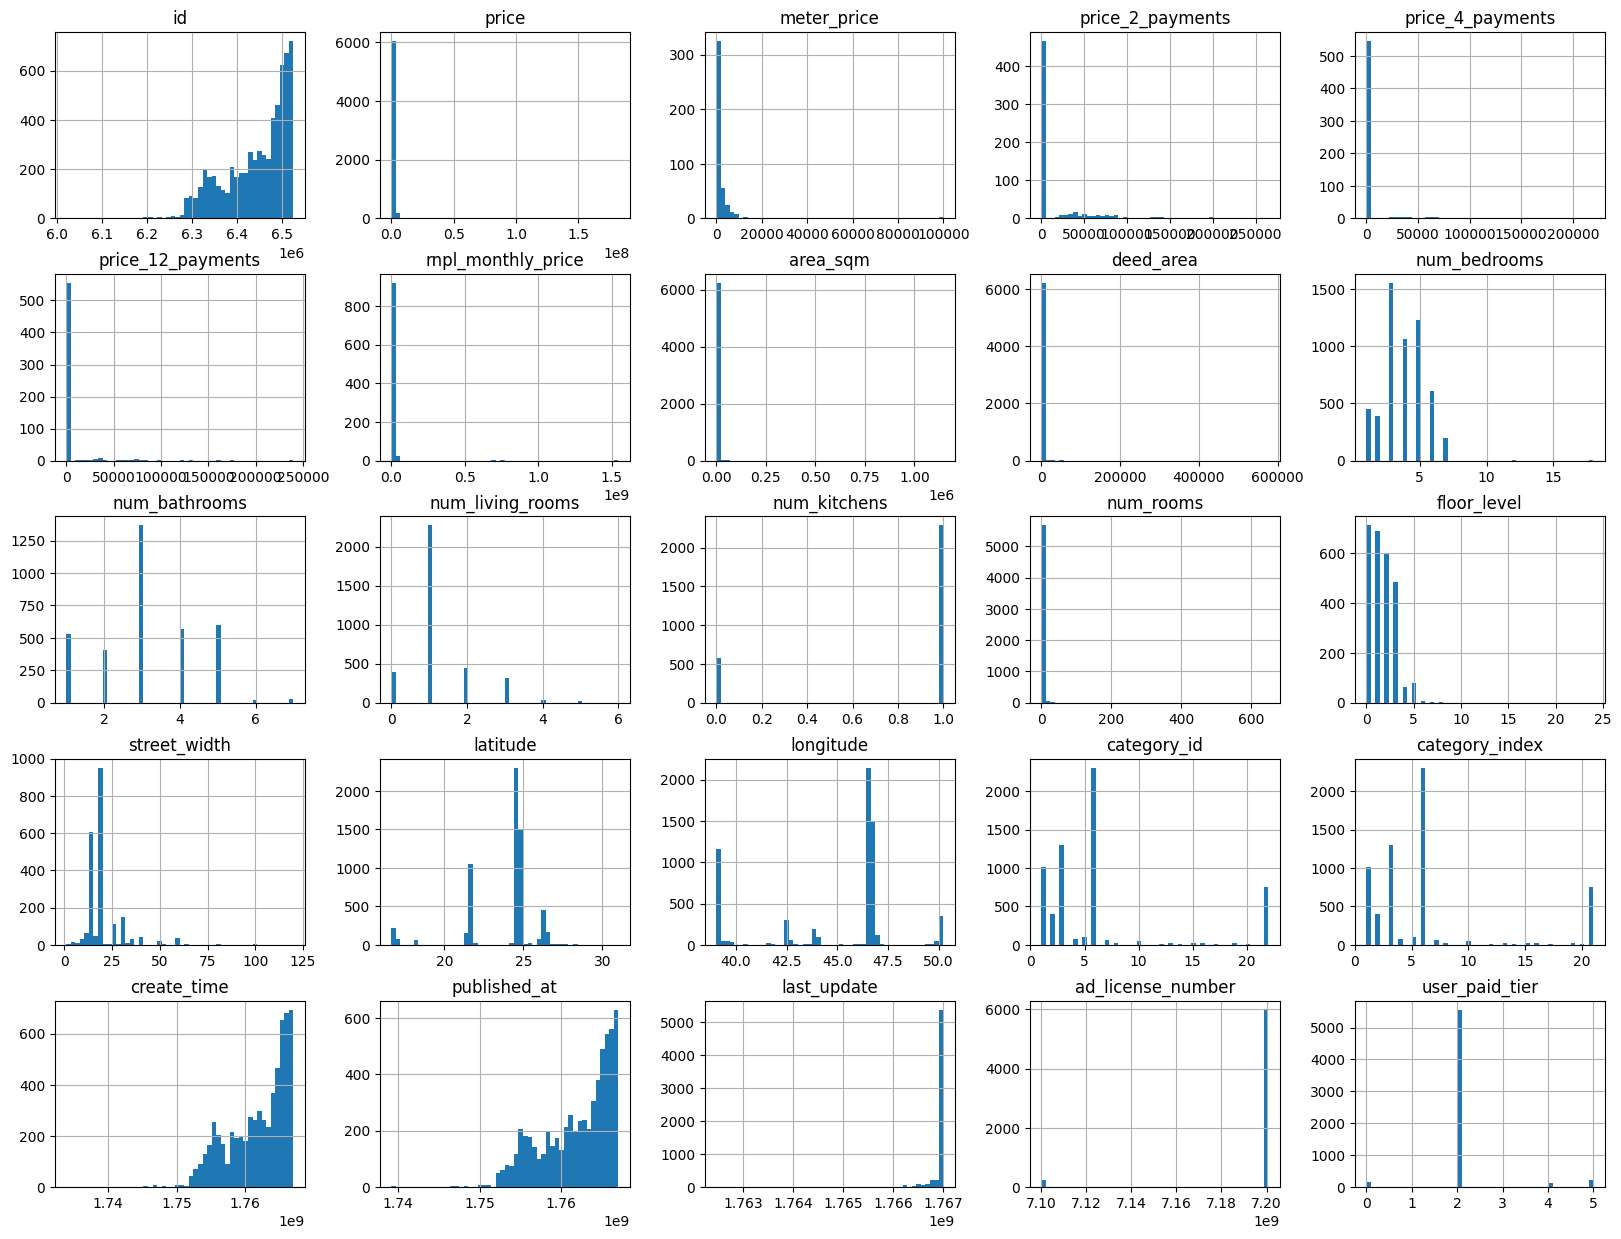

In [28]:
df.hist(bins=50, figsize=(20,15))

array([[<Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_bathrooms'}>,
        <Axes: title={'center': 'lift'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

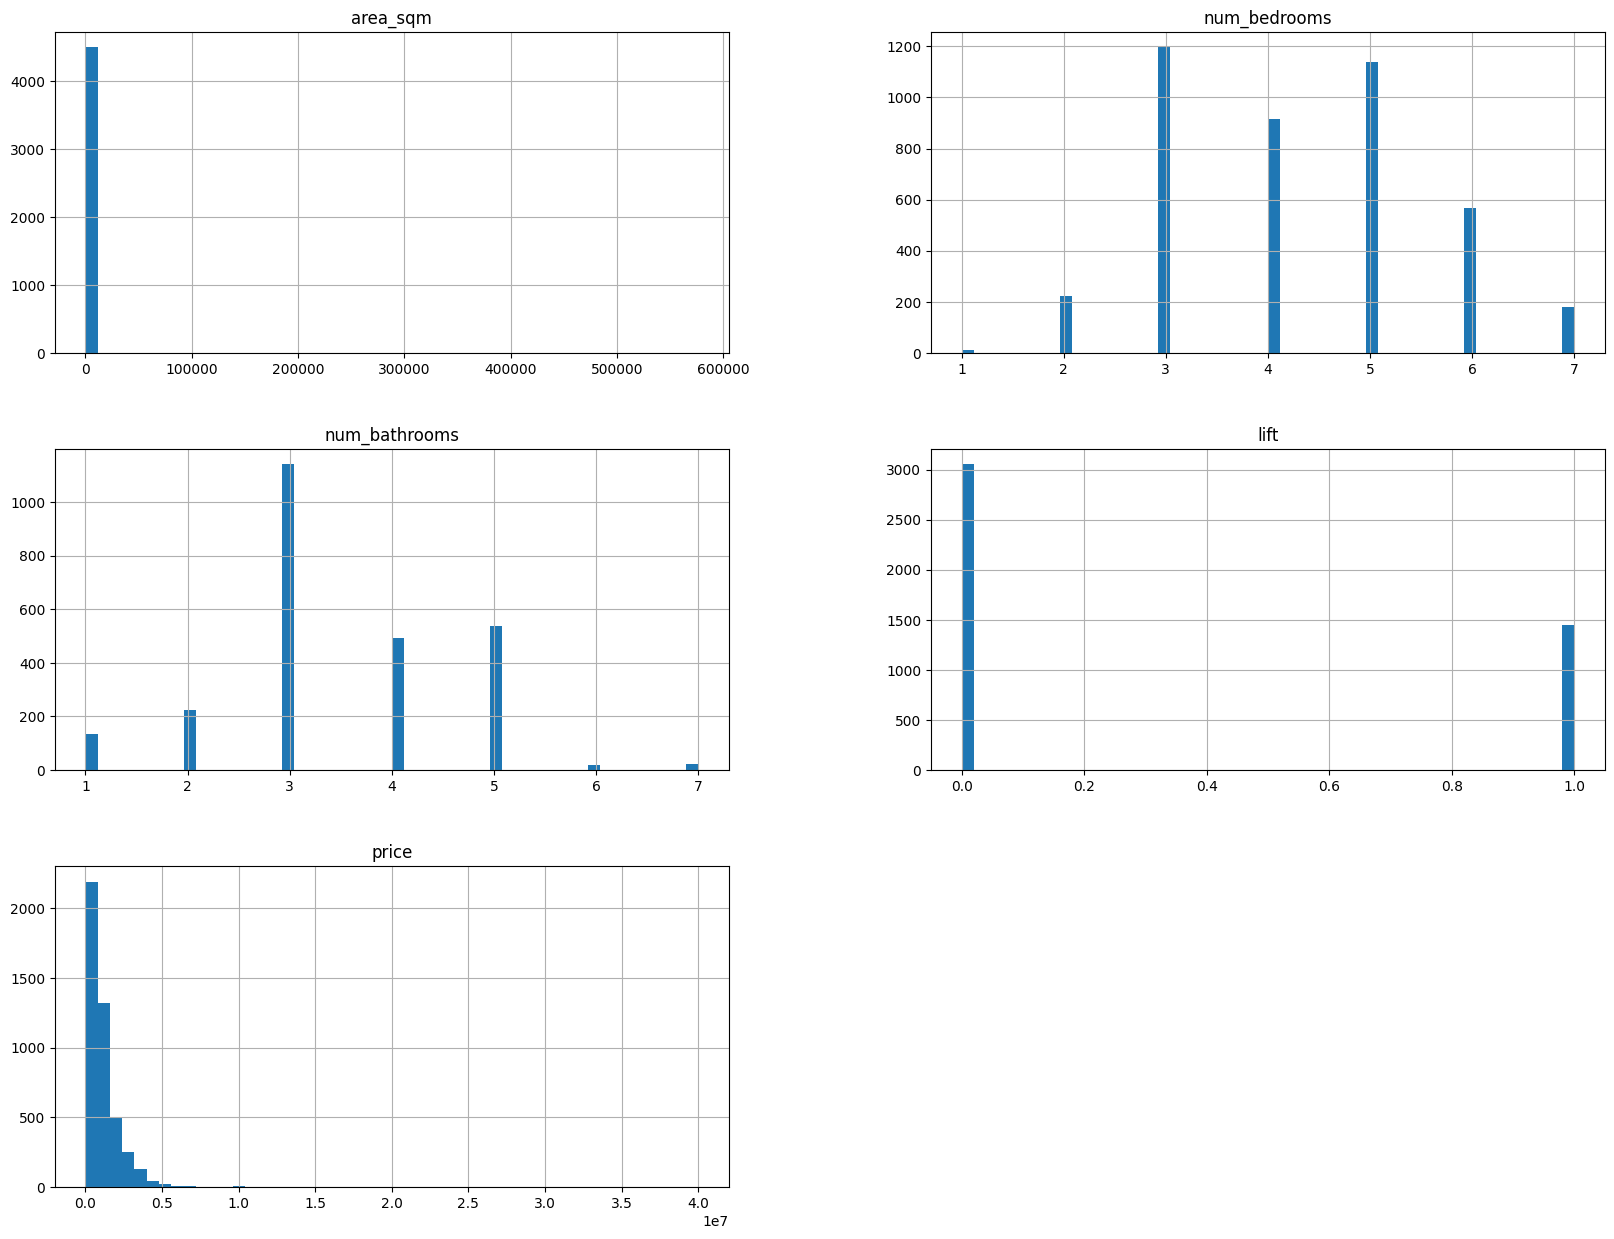

In [29]:

num_feature_cols=["area_sqm","num_bedrooms","num_bathrooms"]
cat_feature_cols=["district","city"]
bool_feature_cols=["lift"]

df = df[(df['is_rental'] == False) & (df['is_daily_rental'] == False) & (df['sale_type'] != 'rent') & (df['sale_type'] !='daily')].copy()
pd.set_option('future.no_silent_downcasting', True)
# drop listings of land without buildings
df=df[df['category_ga_property_category'] != 'land'].copy()
# drop listings of commercial buildings
df=df[(df["category_ga_listing_type"]!= "office") & (df["category_ga_listing_type"]!="store") & (df["category_ga_listing_type"]!="warehouse") & (df["category_ga_listing_type"]!="lounge")].copy()
for bool in bool_feature_cols:
    df[bool] = df[bool].astype(int)

target_col=["price"]

df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].head()

df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].hist(bins=50, figsize=(20,15))



In [30]:
# Profile Data
from ydata_profiling import ProfileReport
profile = ProfileReport(df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].copy(), title="Aqar Dataset Profiling Report")
profile.to_file("aqar_data_profiling_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 464.29it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Data Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

pipe= ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])

pipe.set_output(transform="pandas")

# Define features and target
X = df[num_feature_cols + cat_feature_cols + bool_feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)

print("Preprocessed training data shape:", X_train_prepared.shape)
print("\nFirst few rows of preprocessed data:")
print(X_train_prepared.head())
print("\nColumn names after preprocessing:")
print(X_train_prepared.columns.tolist())

ValueError: Pandas output does not support sparse data. Set sparse_output=False to output pandas dataframes or disable Pandas output via` ohe.set_output(transform="default").

In [ ]:
from ydata_profiling import ProfileReport

X_train_with_target = X_train_prepared.copy()
X_train_with_target['price'] = y_train.values

profile_preprocessed = ProfileReport(X_train_with_target, title="Aqar Preprocessed Data Profiling Report")
profile_preprocessed.to_file("aqar_preprocessed_data_profiling_report.html")
print("Preprocessed data profiling report saved!")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Initialize and train the model
model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}


grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train_prepared, y_train)

# Make predictions
y_pred = grid_search.predict(X_test_prepared)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
model= grid_search.best_estimator_

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print("\nBest parameters:", grid_search.best_params_)
print("\nCoefficients:", grid_search.best_estimator_.coef_)
print("Intercept:", grid_search.best_estimator_.intercept_)


In [ ]:
# grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_prepared, y_train.values.ravel())

In [ ]:
model_rf = grid_search.best_estimator_
model_rf.fit(X_train_prepared, y_train.values.ravel())
y_pred_rf = model_rf.predict(X_test_prepared)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

In [ ]:
cross_val_scores = cross_val_score(model, X_train_prepared, y_train.values.ravel(), cv=5, scoring='r2')
print(f"Cross-validated R^2 scores: {cross_val_scores}")
print(f"Average Cross-validated R^2 score: {cross_val_scores.mean()}")

cross_val_scores_rf = cross_val_score(model_rf, X_train_prepared, y_train.values.ravel(), cv=5, scoring='r2')
print(f"Random Forest Cross-validated R^2 scores: {cross_val_scores_rf}")
print(f"Random Forest Average Cross-validated R^2 score: {cross_val_scores_rf.mean()}")
